In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
from copy import copy
from scipy import stats,signal
import time
import mat73 # this loads .mat files as dicts

sys.path.append('/home1/john/johnModules')
%load_ext autoreload
%autoreload
from general import *


In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# take micro LFP from Matlab and get it ready for processing in PTSA

## load some .mat microLFP, decimate it to 1 kHz, and create a TimeSeries object

In [2]:
from ptsa.data.timeseries import TimeSeries

desired_samplerate = 1000 # Hz

base_fn = '/scratch/john/Sorting/CSC'
csc_nums = np.arange(0,16)+1 # try loading first 16 microelectrodes from patient 555, pre-nap viewing period

begin_time = time.time()

lfp_mat = []
for csc_num in csc_nums:
    fn = base_fn + str(csc_num) + '.mat'
    lfp_mat = superVstack(lfp_mat,mat73.loadmat(fn)['data'])
lfp_mat = signal.decimate(lfp_mat,int(32000/desired_samplerate)) # I think Neuralynx is sampled at 32kHz?
      
time_in_sec = np.linspace(1, np.shape(lfp_mat)[1], np.shape(lfp_mat)[1]) / desired_samplerate
lfp_mat = TimeSeries(lfp_mat,
                dims=('channel', 'time'),
                coords={'channel':csc_nums,
                        'time':time_in_sec,
                        'samplerate':desired_samplerate})
print('Shape of LFP matrix (channel X time):')
print(np.shape(lfp_mat))

Shape of LFP matrix (channel X time):
(16, 3643335)


## filter for line noise, grab power at given frequencies, and append across frequencies

In [3]:
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters import MorletWaveletFilter
from scipy.stats import zscore

buf = 1000  #to remove edge effects during wavelet convolution
spec_freqs = np.logspace(np.log10(3), np.log10(180), 8) # spectral frequencies used in Ezzyat et al 2018
filt_range = [58., 62.] # don't worry about 120 and 180 Hz harmonics since not sampled in spec_freqs

lfp_mat = ButterworthFilter(freq_range=filt_range, filt_type='stop', order=4).filter(timeseries=lfp_mat)

#     # downsample EEG...could do this if necessary to save processing power since we're going to 
#     # bin down to 33.3 ms bins eventually anyway
#     eeg_ptsa = eeg_ptsa.resampled(resampled_rate=500.)
         
#Get spectral power

pow_wavelet = MorletWaveletFilter(freqs=spec_freqs, width=5, output='power', cpus=2).filter(timeseries=lfp_mat)
#output is freqs, events, elecs, and time
# e.g. (8, 240, 141, 700) is 8 logarithmically spaced freqs from 3:180, 240 is trials, 141 elecs, 700 samples (1400 ms each typically)

#remove buffer period added to beginning and end of each trial
#     pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  
#     pows = pow_wavelet.isel(time = ((pow_wavelet.time>=start_time) & (pow_wavelet.time<=end_time)))
#     pows = np.log10(pows)

pow_wavelet = np.log10(pow_wavelet)

#     #Average power across the whole interval
#     avg_pows = pows.mean('time')
#     avg_pows = np.squeeze(avg_pows)

z_pows = zscore(pow_wavelet, axis=2)  #z-score across time

#     z_pows = zscore(avg_pows, axis=1)  #z-score power values across events (important to do within-session)
#     # freqs X trials X electrodes (e.g. 8 X 240 X 141)
#     z_pows = (avg_pows-avg_pows.mean('event'))/avg_pows.std('event')

print(np.shape(z_pows)) # output is frequency X channel X time
# append frequencies together to create time X feature matrix
z_pows = np.array(z_pows).swapaxes(0,2).swapaxes(1,2).reshape(np.shape(pow_wavelet)[2], -1)
print(np.shape(z_pows))


CPP total time wavelet loop:  9.002593040466309
(8, 16, 3643335)
(3643335, 128)


Seconds since started compiling =  275.0914647579193


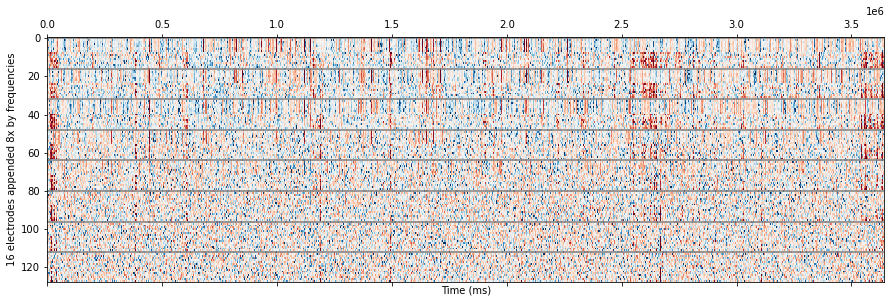

In [4]:
elec_num = np.shape(pow_wavelet)[1]
plt.figure(figsize=(15, 4.5)); ax=plt.subplot(111)
ax.matshow(z_pows.swapaxes(0,1), aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
plt.ylabel(str(elec_num)+' electrodes appended 8x by frequencies')
plt.xlabel('Time (ms)')
for ln in range(8):    
    plt.plot([0, len(z_pows)],[elec_num*ln, elec_num*ln],color=(0.5,0.5,0.5)) 
print("Seconds since started compiling = ", time.time()-begin_time)
a=1;

## HFA example:

In [ ]:
# make sure your trial X time matrix has buffers on either side (something like 300 ms for HFA) so Morlet doesn't give edge effects

HFA_freqs = np.logspace(np.log10(64),np.log10(178),10)

# filter out line noise alias in HFA range
HFA_eeg= ButterworthFilter(timeseries=lfp_mat, freq_range=[118.,122.], filt_type='stop', order=4).filter()
# high pass filter
HFA_eeg = ButterworthFilter(timeseries=HFA_eeg, freq_range=0.5, filt_type='highpass',order=4).filter() 
# get your powers
HFA_morlet = MorletWaveletFilter(timeseries=HFA_eeg1, freqs=HFA_freqs, output='power', width=5, verbose=True).filter()

HFA_eeg = None # delete temp file since it takes up a lot of memory


# now can remove buffers
sr_factor = 1000/sr
HFA_morlet = HFA_morlet[:,:,:,int(eeg_buffer/sr_factor):int(np.shape(HFA_morlet)[3]-(eeg_buffer/sr_factor))]
HFA_morlet = xarray.ufuncs.log10(HFA_morlet, out=HFA_morlet.values)
# resample down to 10 Hz (100 ms bins)
HFA_morlet = ResampleFilter(timeseries=HFA_morlet,resamplerate=10).filter() 
#         # zscore across events & time bins # doing it differently now after talking to Mike 2022-03-08
#         HFA_morlet = (HFA_morlet - np.mean(HFA_morlet, axis=(1,3))) / np.std(HFA_morlet, axis=(1,3)) 
# z-score using std of time-bin averaged instead (mean is same either way)
HFA_morlet = (HFA_morlet - np.mean(HFA_morlet, axis=(1,3))) / np.std(np.mean(HFA_morlet, axis=3),axis=1) 
HFA_morlet = np.mean(HFA_morlet,0) # mean over the 10 frequencies (now down to events X pairs X 100 ms bins)